# Classifying Bangla Fake News with HuggingFace Transformers and Fastai


- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In this post we cover fine tuning a [multilingual BERT](https://huggingface.co/bert-base-multilingual-cased) model from Huggingface Transformers library on [**BanFakeNews**](https://aclanthology.org/2020.lrec-1.349/) dataset released in LREC 2020. While English Fake News Classification and fact checking tasks have many resources and competitions available such as [fake news challenge](http://www.fakenewschallenge.org/) and [hateful meme detection](https://ai.facebook.com/blog/hateful-memes-challenge-and-data-set/), similar efforts in Bangla has been almost non existent. BanFakeNews dataset contains 50k annotated articles from different news sources in Bangladesh, out of them around 1200 articles have been annotated as fake. As transformer architectures uses self attention to learn contextual embeddings they have been very popular in NLP research community for a while and many tools have been built around them.

This post is reusing materials taught in Weights and Bias's study group of Fast ai with Huggingface([link](https://wandb.ai/wandb_fc/events/reports/W-B-Study-Group-Lectures-fast-ai-w-Hugging-Face--Vmlldzo4NDUzNDU?galleryTag=events)) where several recent(2021) libraries([Blurr](https://github.com/ohmeow/blurr),[Fasthugs](https://github.com/morganmcg1/fasthugs) & [Adaptnlp](https://novetta.github.io/adaptnlp/)) that integrates components from popular deep learning frameworks Huggingface transformers and Fastai v2 are shown. 

My experience with using Transformers is fairly low, recently I participated in Huggingface's Flax/Jax week and there our team pretrained [Bengali GPT2](https://huggingface.co/flax-community/gpt2-bengali) and [T5](https://huggingface.co/flax-community/Bengali-t5/tree/main), so I was looking into Huggingface course and documentation to learn more about how to finetune transformers. Previously my thesis journal paper for undergraduate ["Deep Learning based Question Answering System in Bengali"](https://www.tandfonline.com/doi/full/10.1080/24751839.2020.1833136) worked on Bangla Question Answering with transformers, but I had stuck more to given scripts back then and focused more on synthetic dataset construction via translation and handling data corruption issues. So this post will focus more on the high level API of ```Blurr``` and the components of huggingface and fastai that are relevant for getting started quickly. 

In [ ]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr
!pip install -Uqq wandb

# Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import wandb

from transformers import *
from fastai.text.all import *
from fastai.callback.wandb import *


from blurr.data.all import *
from blurr.modeling.all import *

We will use weights and biases for tracking experiments and runs. Project page : https://wandb.ai/tasmiah-tahsin/fake-news-blurr

In [ ]:
wandb.login()

wandb: Currently logged in as: tasmiah-tahsin (use `wandb login --relogin` to force relogin)


True

# Load dataset

This dataset has been downloaded from [Kaggle](https://www.kaggle.com/cryptexcode/banfakenews). Note that there are four files in the given dataset, but we use the two files (Authentic-48k and fake-1k) here because the rest of the files contain labelled fake and authentic news. Labelling in the sense of what type of fake news it is, clickbait, satire, misleading or false context, for the current priliminary phase we stick to binary classification of knowing if a news is fake or authentic. We also concatanate headline and content of the news article during preprocessing and combine the fake and authentic news dataset before sending them to Blurr dataloaders.



![](../images/fakenews/dataset_preview.png)

In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/fake news/Fake-1K.csv")
authentic = pd.read_csv("/content/drive/MyDrive/fake news/Authentic-48K.csv",engine='python',error_bad_lines=False,warn_bad_lines=True)
df = pd.concat([authentic[['headline','content','label']],fake[['headline','content','label']]])
df.reset_index(drop=True,inplace=True)

In [ ]:
print(authentic.shape, fake.shape)

(48678, 7) (1299, 7)


In [ ]:
df['text'] = df['headline'] + df['content']

In [ ]:
df = df.drop(['headline','content'],axis=1)

In [ ]:
df.head(1)

,label,text
0,1,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজগত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে (বাকৃবি) উপাচার্যের কার্যালয়ে হট্টগোলের ঘটনায় দুইজনকে সাময়িক বরখাস্ত ও ছয় জনকে শোকজ করেছে বিশ্ববিদ্যালয় প্রশাসন। বুধবার বিশ্ববিদ্যালয় বাকৃবি রেজিস্ট্রার সাইফুল ইসলাম স্বাক্ষরিত এক নোটিশে আগামী ৭ দিনের মধ্যে উপযুক্ত উত্তর দেয়ার নির্দেশ দেয়া হয়েছে। এদিকে এ ঘটনায় আন্দোলনের সঙ্গে একাত্বতা প্রকাশ না করায় হামলার শিকার হয়ে কারিগরি কর্মচারী পরিষদের সভাপতি ও সাধারণ সম্পাদক হাসপাতালে ভর্তি হয়েছেন। সাময়িক বরখাস্তরা হলেন- শিক্ষা বিষয়ক শাখার কর্মচারী ও ৩য় শ্রেণির সাধারণ সম্পাদক মো. মোশারফ হোসেন ও কর্মকর্তা পরি..."


In [ ]:
df.label=df.label.map({1:"Authentic",0:"Fake"})

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.3)

We will use ```Blurr``` high level API for sequence classification with the pandas dataframe where ```BlearnerForSequenceClassification.from_dataframe()``` method takes in a dataframe, splits them from the column of default ```is_valid``` using Fastai's [```ColSplitter```](https://docs.fast.ai/data.transforms.html#ColSplitter) into train and test splits, constructs the datablock and dataloaders and uses them for training. So we add a ```'is_valid'``` column in the dataframe. There are other ways of splitting the data available in Fastai like ```RandomSubsetSplitter``` where we can randomize the data inside a dataframe. Since we used scikit-learns train test split to shuffle the dataframe for now we can go with Column based splitting. 

In [ ]:
train.loc[:,'is_valid'] = False
valid['is_valid'] = True

In [ ]:
final_df = pd.concat([train,valid],axis=0)

In [ ]:
final_df.head()

,label,text,is_valid
16428,Authentic,"সোচ্চার না হলে স্বাধীন ও মুক্ত সাংবাদিকতা অবরুদ্ধ হয়ে পড়বেজাতীয় প্রেস কাব ও বাংলাদেশ ফেডারেল সাংবাদিক ইউনিয়নের সাবেক সভাপতি এবং নিউজ টুডে সম্পাদক রিয়াজ উদ্দিন আহমেদ বলেছেন, ডিজিটাল নিরাপত্তা আইনে পুলিশকে যেভাবে ঢালাও ক্ষমতা দেয়া হয়েছে তাতে স্বাধীন সাংবাদিকতা অবরুদ্ধ হয়ে পড়বে। মুক্ত ও অবাধ তথ্যপ্রবাহ বলে কিছুই অবশিষ্ট থাকবে না। সাংবাদিকরা সেল্ফ সেন্সরশিপ আরোপ করতে বাধ্য হবেন। মত প্রকাশের ক্ষেত্রে এমন কালো আইনের বিরুদ্ধে সবাইকে সোচ্চার হতে হবে এখনই। নয়া দিগন্তকে দেয়া এক একান্ত সাক্ষাৎকারে রিয়াজ উদ্দিন আহমেদ আরো বলেন, ব্রিটিশ ঔপনিবেশিক আমলেও এমন আইন হয়নি। সমাজের প্রকৃত সত্য ধামাচাপা দিতে এবং ...",False
31438,Authentic,সাউথইস্ট বিশ্ববিদ্যালয়ের বিজ্ঞান ও প্রকৌশল অনুষদে নবীনবরণ অনুষ্ঠিতসাউথইস্ট বিশ্ববিদ্যালয়ের বিজ্ঞান ও প্রকৌশল অনুষদের ফল সেমিস্টারে ভর্তি হওয়া নবাগত শিক্ষার্থীদের নবীনবরণ অনুষ্ঠিত হয়। সোমবার বিশ্ববিদ্যালয়ের তেজগাঁওয়ের স্থায়ী ক্যাম্পাসের সেমিনার হলে এ অনুষ্ঠান হয়। বিশ্ববিদ্যালয়ের উপাচার্য অধ্যাপক ড. এএনএম মেশকাত উদ্দীনের সভাপতিত্বে অনুষ্ঠানে প্রধান অতিথির বক্তব্য রাখেন ভিয়েলা টেক্স গ্রুপের চেয়ারম্যান জনাব কে এম রেজাউল হাসানাত এবং বিশেষ অতিথি ছিলেন ঢাকা ইমপেরিয়াল কলেজের অধ্যক্ষ জনাব আরিফ আহমেদ। স্বাগত বক্তব্য রাখেন সাউথইস্ট বিশ্ববিদ্যালয়ের রেজিস্ট্রার মেজর জেনারেল (অব.) কাজী ফকরুদ্দীন আহমেদ। ...,False
10367,Authentic,"মাগুরায় সড়ক দুর্ঘটনায় শালা-দুলাভাই নিহতমাগুরায় সড়ক দুর্ঘটনায় দুই মোটরসাইকেল আরোহী নিহত হয়েছেন। সোমবার সকালে পৌর এলাকার পারনান্দুয়ালী এলাকায় এ ঘটনা ঘটে। নিহতরা হলেন- মাগুরা শহরের কাউন্সিল পাড়ার মৃত শাহাজাদার ছেলে মনিরউদ্দিন তালুকদার লাভলু (৩৮) ও তার শ্যালক সৌদী প্রবাসী নিয়ামুল (২৫)। নিয়ামুল ফরিদপুরের ভাঙ্গা উপজেলার আব্দুল ওয়াদুদের ছেলে। মনিরউদ্দিন লাভলু মাগুরা শহরে সাকুরা কালার ল্যাবে চাকরি করতেন। মাগুরা সদর থানার এসআই মুবিন জানান, মনিরউদ্দিন লাভলু ও নিয়ামুল মাগুরা থেকে মোটরসাইকেলে শ্রীপুর উপজেলার রাধানগর বাজারে দুধ কিনতে যাচ্ছিলেন। মাগুরা পৌর এলাকার পারনান্দুয়ালী নামকস্থানে একটি কাভা...",False
24556,Authentic,"৭ বিশ্ববিদ্যালয়ের শিক্ষার্থী নিয়ে ‘ইন্সপিরেশন ফর হিউম্যান ওয়েলফেয়ার’সামাজিক সচেতনতামূলক সংগঠন ইন্সপিরেশন ফর হিউম্যান ওয়েলফেয়ার (আইএইচডাব্লিউ) নামক সংগঠনের কার্যনির্বাহী কমিটি গঠন করা হয়েছে। আজ ৩০ সেপ্টেম্বর গোপালগঞ্জে অনুষ্ঠিত একসভায় দেশের ৭টি পাবলিক বিশ্ববিদ্যালয়ের শিক্ষার্থীদের নিয়ে এ সংগঠনের আত্মপ্রকাশ ঘটে। বিশ্ববিদ্যালয়গুলো হলো ঢাকা বিশ্ববিদ্যালয়, জগন্নাথ বিশ্ববিদ্যালয়, বঙ্গবন্ধু বিজ্ঞান ও প্রযুক্তি বিশ্ববিদ্যালয়, যশোর বিজ্ঞান ও প্রযুক্তি বিশ্ববিদ্যালয়, পাবনা বিজ্ঞান ও প্রযুক্তি বিশ্ববিদ্যালয়, বরিশাল বিশ্ববিদ্যালয় ও খুলনা বিশ্ববিদ্যালয়। সভায় সর্বসম্মতিক্রমে বঙ্গবন্ধু শেখ মুজিবুর রহমান ...",False
24776,Authentic,"মন্ত্রীর বাড়ির সৌন্দর্য রক্ষায় দোকান ভাংচুর, লুটপাট : ব্যবসায়ীদের মানববন্ধন ও বিক্ষোভবেসামরিক বিমান পরিবহন ও পর্যটন মন্ত্রী একেএম শাহজাহান কামালের বাড়ির সৌন্দর্য রক্ষায় লক্ষ্মীপুরে দোকান-পাট ভাংচুর ও লুটপাটের অভিযোগ করছে ব্যবসায়ীরা। এ ঘটনার প্রতিবাদে ব্যবসায়ীরা মানববন্ধন ও বিক্ষোভ সমাবেশ করছে। রবিবার দুপুরে শহরের চকবাজার এলাকায় ঘন্টাব্যাপী মানববন্ধন ও বিক্ষোভ সমাবেশ করে ব্যবসায়ীরা। এ সময় বক্তব্য রাখেন, লাবনী ফ্যাশনের মালিক আলাউদ্দিন, আল-আমিন ফার্মেসীর মালিক পরাজিত বাবু প্রমুখ। ব্যবসায়ীরা অভিযোগ করে বলেন, জেলা পরিষদ থেকে ইজারা নিয়ে শত বছর ধরে এখানে ব্যবসা করে আসছেন তারা। পাশে বেসামরিক বিমান...",False


# Model

## Multilingual BERT

Since the original paper also used [multilingual cased bert](https://github.com/google-research/bert/blob/master/multilingual.md) released by Google this post can be considered as an attempt to reproduce the work of BanFakeNews. They trained mbert for 50 epochs with a learning rate of 0.00002 and optimizer Adam. The batch size was 32. The overall F1 score after training for 50 epochs on this dataset was .99 and f1 for fake class was 0.68. Multilingual bert has been pretrained on 104 languages including bengali with wordpiece tokenization. As bengali is already included it makes it a valid choice for current bangla text classification task. Information for this model are : 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters.  As the size of the language corpora varied greatly for low resource languages exponential weighted smoothing was performed for weighting data during the pretraining stage, which results in undersampling high resource languages like english and oversampling low resource languages like Bengali. Mbert does not use any marker for input language to enable zero shot training.

In [ ]:
wandb_init_kwargs = {
    'reinit': True, 
    'project': "fake-news-blurr", 
    'entity': "tasmiah-tahsin",
    'notes': 'Finetuning banfakenews with multilingual bert via Blurr', 
    'tags': ['mbert', 'fake-news-classification', 'blurr']
  }

In [ ]:
wandb.init(**wandb_init_kwargs)

Since I'm fairly new in ```blurr``` I'm using the high level API, but the key ideas are following. ```blurr``` is integrating two frameworks. Here ```Fastai``` is providing the ```datablock```, ```learner```, ```learning rate finder``` functionalities with Leslie Smith's 1cycle policy components, while huggingface transformers is providing the ready to use transformer model configuration and architectures made publicly available from huggingface hub. 

Fastai's datablock helps to quickly transform a raw dataset to a mini-batch that can be sent to a model for training with its various transforms and splitting functions along with visualization capacities. Under the hood ```blurr``` is providing wrappers for the huggingface transformers and for finetuning its also grouping the parameters of the transformers model along with enabling discriminative fine tuning like  [ULMFiT](https://paperswithcode.com/method/ulmfit). Discriminative finetuning refers to using variable learning rates for different layers of a neural network and they can also change during training(increasing or decreasing learning rate will change how much the parameters are updated during each step).

Datablock transforms can operate on both item and batch level. Fastai also provides the capacity add callbacks in the training loop. Callbacks are a generic programming concept which refers to calling a function inside another function(the base function calls the callback function, hence the naming) and are extensively used in DL training loops to perform specific tasks during the forward pass, loss calculation, backward pass and optimizer step taking for issues like changing learing rates and more. 

The low level API for ```blurr```  works with datablocks and dataloaders  creating the mini batches which are combined with the model architecture, optimizer and loss function inside a ```learner```. Mid level API contains ```BLearner``` and the highest level API contains task specific learners like the current one I'm using which is ```BlearnerForSequenceClassification```.  




In [ ]:
from blurr.modeling.core import BlearnerForSequenceClassification
pretrained_model_name = "bert-base-multilingual-cased"
learn = BlearnerForSequenceClassification.from_dataframe(final_df, pretrained_model_name, dl_kwargs={ 'bs': 4})

SuggestedLRs(minimum=0.002290867641568184, steep=0.0010000000474974513, valley=0.0004786300996784121, slide=0.02290867641568184)

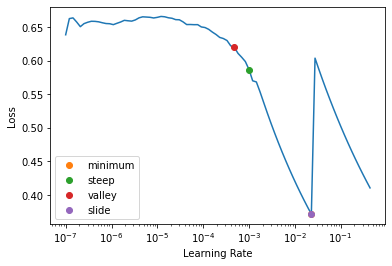

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
learn.freeze()
learn.fit_one_cycle(1, lr_max=1e-2,cbs=[WandbCallback(log_preds=False, log_model=False)])

Could not gather input dimensions


epoch,train_loss,valid_loss,f1_score,accuracy,time


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=1e-2,cbs=[WandbCallback(log_preds=False, log_model=False)])

In [ ]:
learn.show_results(learner=learn, max_n=4,trunc_at=200)

,text,category,target
0,"আফগানদের ছিটকে বাংলাদেশের রুদ্ধশ্বাস উত্তেজনার ম্যাচে ৩ রানে জিতেছে বাংলাদেশ । ২৪৯ রান আফগানিস্তান থেমেছে ২৪৬ রানে । সংক্ষিপ্ত স্কোর : বাংলাদেশ : ৫০ ওভারে ২৪৯ / ৭ ( লিটন ৪১, শান্ত ৬, মিঠুন ১, মুশফিক ৩",Authentic,Authentic
1,"এলেবেলে : খাল কেটে কুমীর আনবেন না, সিদ্দিককে ভোট দেবেন না [ আহমেদের'এলেবেলে'বাংলা রম্য সাহিত্যে এক অনন্য সংযোজন । এর শিরোনামের রচনাগুলো তিনি তার ছোট ভাই আহসান হাবীবের প্রকাশিত মাসিক উন্মাদের জন্য লিখা",Fake,Fake
2,"বিএনপি শুদু লাঞ্ছনা বঞ্ছনা গঞ্জনা : শমশের | দৈনিক মতিকণ্ঠনিজস্ব মতিবেদকরাজনীতী হতে অবসর ঘোষনা বৃহত্তর ইসলামীর বিএনপি শাখার খারিজি, বৃহত্তর ইসলামীর বিএনপি শাখার মহিলা আমীর ও শক্তির মালিক আপোষহীন দেশনেত",Fake,Fake
3,"বোকো হারাম - গন্তব্য কতদূর? বোকো হারাম উগ্রপন্থী দল । পশ্চিম প্রথমে গঠিত জামাত আহলে সুন্নাহ লিদ জিহাদ, এটিই কিছুদিন পর বোকো হারাম নামে পরিচিতি । এদের মূল বক্তব্য হলো, পশ্চিমা শিক্ষা - সংস্কৃতি নিষিদ্ধ",Authentic,Authentic


In [ ]:
wandb.finish()

epoch,5
train_loss,0.08289
raw_loss,0.07101
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss,▇██▇▆▅▅▅▅▅▃▅▄▄▂▄▄▃▃▃▂▂▃▃▁▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
raw_loss,▇▃▃▇▃▃▆▂▃▅▁▆▆▁▁▇▁▁▆▄▅▁▃▄▁▆▂▄▂▃▂▁▄▁▁▁▁█▁▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁


# Model Sharing

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,676 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 160837 files and directories c

In [ ]:
!transformers-cli login

2021-08-05 07:17:22.031785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: Tahsin-Mayeesha
Password: 
Login successful
Your token: oSBeuCeqFwuZgHGyqIBjgHEmiAchBfqCTsadczfjKMwdGdOskZjIvLzkFxbQafNAbNHwgsNibftTGdtUfMvWLkBjGwsMGfpdekOyyFbWFVOOJUkktSsdoacPJeeuZkhi 

Your token has been saved to /root/.huggingface/token


In [ ]:
!git config --global user.email "tasmiah.tahsin@northsouth.edu"

In [ ]:
!git config --global user.name "Tahsin-Mayeesha"

In [ ]:
blurr_tfm = get_blurr_tfm(learn.dls.before_batch)

In [ ]:
blurr_tfm.hf_model.push_to_hub("bangla-fake-news-mbert",use_temp_dir=True)

'https://huggingface.co/Tahsin-Mayeesha/bangla-fake-news-mbert/commit/2485b1ab7750b7746e6a052bf72f6c8871e8ecd4'

In [ ]:
blurr_tfm.hf_tokenizer.push_to_hub("bangla-fake-news-mbert",use_temp_dir=True)

PanicException: ignored

# Explaining predictions

In [ ]:
sample news = 

In [ ]:
!pip install transformers-interpret


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "Tahsin-Mayeesha/bangla-fake-news-mbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# With both the model and tokenizer initialized we are now able to get explanations on an example text.

from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)
word_attributions = cls_explainer("I love you, I like you")


In [ ]:
cls_explainer.visualize